# PDFNet Demo - Updated for New Inference API

This notebook demonstrates PDFNet's dichotomous image segmentation capabilities.

**Note:** Cells 1-5 have been updated to use the modern `PDFNetInference` API. The remaining cells (6+) contain legacy benchmarking code that still uses the old direct model API and are kept for reference. To run them, you would need to restore the old helper functions.

## Quick Start
Run cells 1-5 to see the new simplified API in action!


In [ ]:
# PDFNet Demo - Dichotomous Image Segmentation with MoGe Depth Estimation

import sys
from pathlib import Path
import time
from statistics import mean, stdev

import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Add project root to path before local imports
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import local modules after path setup - using new inference API
from pdfnet.inference import PDFNetInference  # noqa: E402
from pdfnet.config import PDFNetConfig  # noqa: E402

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load Models

print("Loading models...")

# Create config and load PDFNet model
config = PDFNetConfig()
config.device = str(device)
config.model.checkpoint = "checkpoints/PDFNet_Best.pth"
config.inference.use_moge = True

# Load PDFNet using the modern inference API
pdfnet = PDFNetInference(config=config, checkpoint_path="checkpoints/PDFNet_Best.pth")

# Access the underlying model for direct inference if needed
model = pdfnet.model

# Load MoGe model separately for direct access
moge_model = MoGeModel.from_pretrained("checkpoints/moge/moge-2-vitl-normal/model.pt")
moge_model = moge_model.to(device).eval()

print("Models loaded successfully")

Loading models...
Models loaded successfully


In [ ]:
# Helper Functions (using new API)


def load_image(image_path):
    """Load and convert image to RGB."""
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [ ]:
# Inference Functions (using new API)


def run_inference_simple(image_path, use_tta=False):
    """
    Simple inference using the new PDFNetInference API.

    Args:
        image_path: Path to input image
        use_tta: Whether to use test-time augmentation

    Returns:
        Prediction mask as numpy array (H, W) with values [0, 1]
    """
    if use_tta:
        # Use built-in TTA support
        result = pdfnet.predict_with_tta(image_path, flips=["horizontal", "vertical"])
    else:
        # Standard inference
        result = pdfnet.predict_single(image_path)

    return result

In [5]:
# Main Demo Function


def run_pdfnet_demo(image_path="pics/37.png", use_tta=False):
    print(f"Processing: {image_path} (TTA: {use_tta})")

    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not load image: {image_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    depth = process_image_with_moge(img, moge_model, device)

    img_resized = cv2.resize(img, (1024, 1024))
    depth_resized = cv2.resize(depth, (1024, 1024))

    transforms = GOSNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255
    img_tensor = transforms(img_tensor).unsqueeze(0)
    depth_tensor = torch.from_numpy(depth_resized).unsqueeze(0).unsqueeze(0) / 255

    if use_tta:
        tta_result = run_pdfnet_inference_with_tta(
            model, img_tensor.to(device), depth_tensor.to(device), device, use_tta=True
        )
        if isinstance(tta_result, torch.Tensor):
            DIS_map = tta_result[0][0].cpu()
        else:
            DIS_map = tta_result[0][0][0].cpu()
    else:
        with torch.no_grad():
            standard_result = model.inference(
                img_tensor.to(device), depth_tensor.to(device)
            )
        DIS_map = standard_result[0][0][0].cpu()

    DIS_map_final = process_segmentation_output(DIS_map, W, H)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(depth, cmap="plasma")
    plt.title("MoGe Depth Map")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(DIS_map_final, cmap="gray")
    plt.title(f"PDFNet Result {'(TTA)' if use_tta else ''}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("Done")
    return DIS_map_final


Processing: pics/37.png (TTA: False)


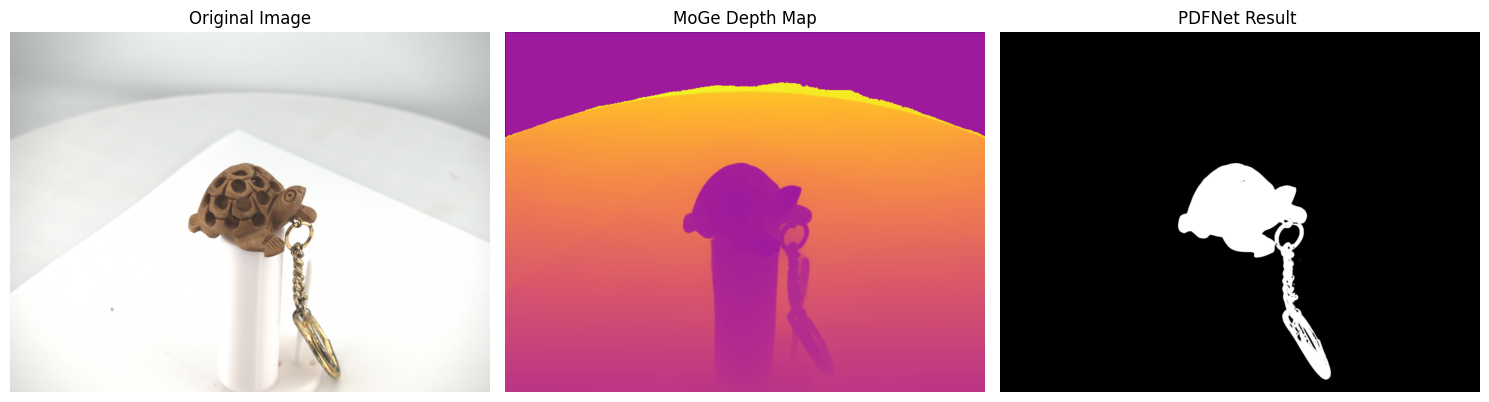

Done
Processing: pics/37.png (TTA: True)


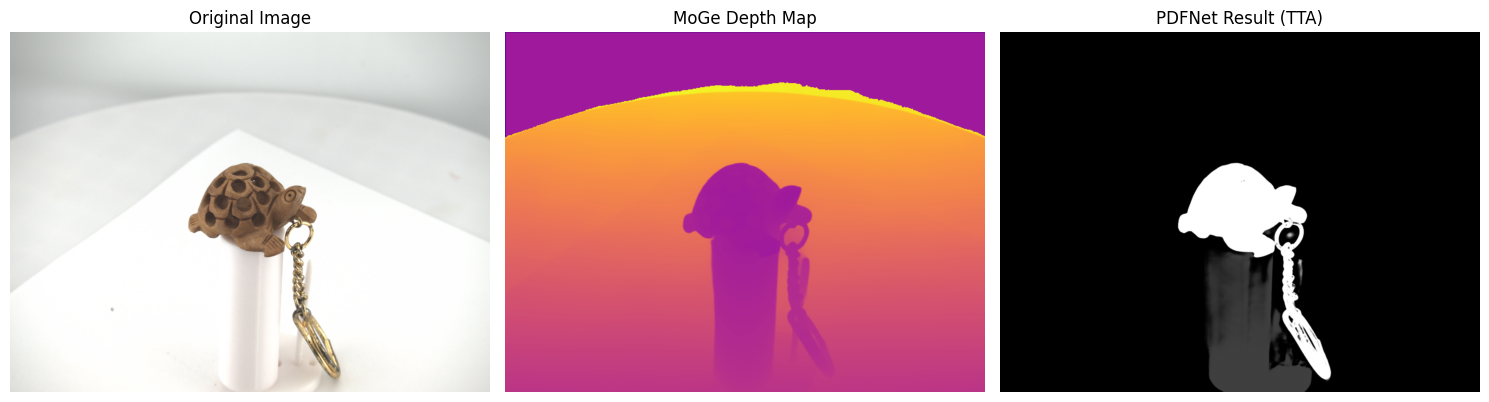

Done


In [7]:
# Compare TTA vs Standard

result_standard = run_pdfnet_demo(image_path="pics/37.png", use_tta=False)
result_tta = run_pdfnet_demo(image_path="pics/37.png", use_tta=True)


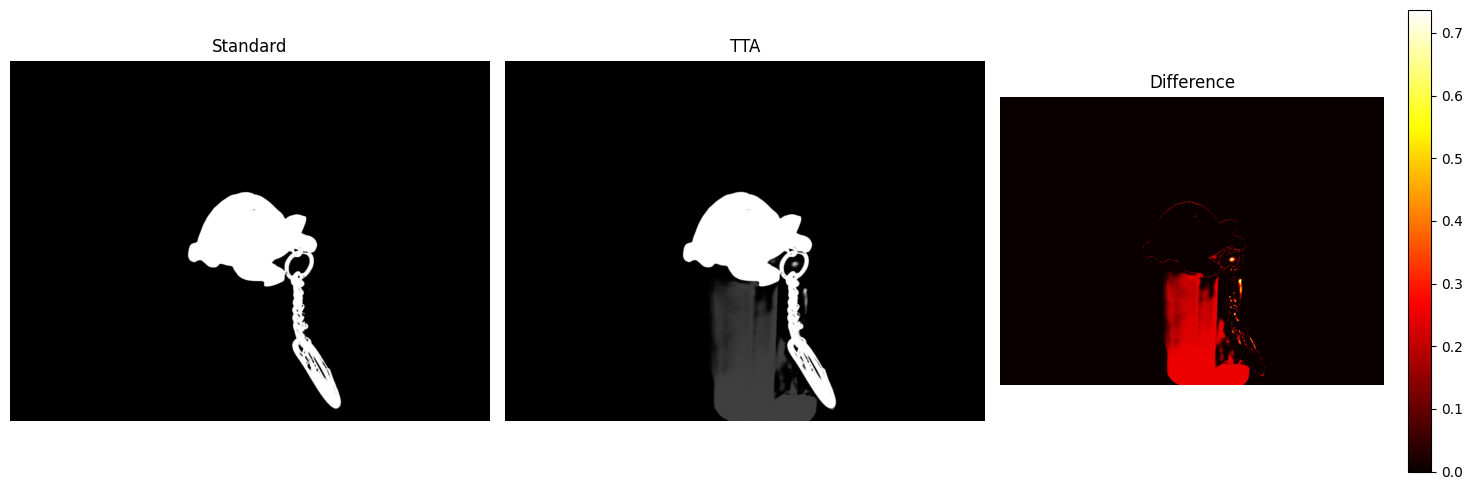

Mean diff: 0.0135, Max diff: 0.7367, Correlation: 0.9724


In [8]:
# Visualize Differences

if result_tta is not None and result_standard is not None:
    diff = np.abs(result_tta.astype(float) - result_standard.astype(float))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(result_standard, cmap="gray")
    plt.title("Standard")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(result_tta, cmap="gray")
    plt.title("TTA")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(diff, cmap="hot")
    plt.title("Difference")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    correlation = np.corrcoef(result_tta.flatten(), result_standard.flatten())[0, 1]
    print(
        f"Mean diff: {diff.mean():.4f}, Max diff: {diff.max():.4f}, Correlation: {correlation:.4f}"
    )

In [ ]:
# Batch Processing Support
def process_batch_with_moge(image_batch, model, device):
    """Process a batch of images with MoGe to get depth maps."""
    batch_size = image_batch.shape[0]
    input_size = 518

    # Resize all images in batch
    images_resized = torch.nn.functional.interpolate(
        image_batch, size=(input_size, input_size), mode="bilinear", align_corners=False
    )

    # Run batch inference
    with torch.no_grad():
        moge_output = model.infer(images_resized)
        depth_batch = moge_output["depth"]

        # Handle different depth formats
        if depth_batch.dim() == 4 and depth_batch.shape[1] == 1:
            depth_batch = depth_batch.squeeze(1)  # Remove channel dim if present
        elif depth_batch.dim() == 3:
            pass  # Already correct format (B, H, W)

        # Clean invalid values for entire batch
        depth_batch_np = depth_batch.cpu().numpy()
        if np.isnan(depth_batch_np).any() or np.isinf(depth_batch_np).any():
            depth_batch_np = np.nan_to_num(
                depth_batch_np, nan=0.0, posinf=1.0, neginf=0.0
            )

        # Normalize each image in batch individually
        normalized_batch = []
        for i in range(batch_size):
            depth_np = depth_batch_np[i]
            depth_min, depth_max = depth_np.min(), depth_np.max()
            if depth_min == depth_max:
                depth_normalized = np.full_like(depth_np, 128.0)
            else:
                depth_normalized = (
                    (depth_np - depth_min) / (depth_max - depth_min) * 255.0
                )

            depth_normalized = np.clip(depth_normalized, 0, 255)
            normalized_batch.append(depth_normalized.astype(np.uint8))

        return np.stack(normalized_batch)


def run_pdfnet_batch_inference(image_batch, depth_batch, model, device, use_tta=False):
    """Run PDFNet inference on a batch of images with manual flip TTA"""
    image_batch.shape[0]

    if use_tta:
        # TTA with batch processing using manual flips
        predictions = []

        with torch.no_grad():
            with autocast(enabled=torch.cuda.is_available(), device_type="cuda"):
                # Original prediction
                pred_output = model.inference(image_batch, depth_batch)
                if isinstance(pred_output, (list, tuple)):
                    pred = pred_output[0]
                else:
                    pred = pred_output
                predictions.append(pred)

                # Horizontal flip
                img_h = torch.flip(image_batch, dims=[3])
                depth_h = torch.flip(depth_batch, dims=[3])
                pred_output = model.inference(img_h, depth_h)
                if isinstance(pred_output, (list, tuple)):
                    pred = pred_output[0]
                else:
                    pred = pred_output
                pred_h = torch.flip(pred, dims=[3])
                predictions.append(pred_h)

                # Vertical flip
                img_v = torch.flip(image_batch, dims=[2])
                depth_v = torch.flip(depth_batch, dims=[2])
                pred_output = model.inference(img_v, depth_v)
                if isinstance(pred_output, (list, tuple)):
                    pred = pred_output[0]
                else:
                    pred = pred_output
                pred_v = torch.flip(pred, dims=[2])
                predictions.append(pred_v)

        # Average all predictions
        final_pred = torch.stack(predictions).mean(dim=0)
        return final_pred
    else:
        # Standard batch inference
        with torch.no_grad():
            with autocast(enabled=torch.cuda.is_available(), device_type="cuda"):
                result = model.inference(image_batch, depth_batch)
        return result


def batch_demo(image_paths, batch_size=4, use_tta=False):
    """Demo function for batch processing multiple images"""

    print("🚀 BATCH PROCESSING DEMO")
    print(f"Images: {len(image_paths)}")
    print(f"Batch size: {batch_size}")
    print(f"TTA enabled: {use_tta}")
    print("=" * 60)

    # Process images in batches
    all_results = []
    total_batches = (len(image_paths) + batch_size - 1) // batch_size

    for batch_idx in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[batch_idx : batch_idx + batch_size]
        current_batch_size = len(batch_paths)

        print(
            f"\\nProcessing batch {(batch_idx // batch_size) + 1}/{total_batches} ({current_batch_size} images)"
        )

        # Load and prepare batch
        batch_images = []
        batch_original_sizes = []

        for img_path in batch_paths:
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Could not load {img_path}, skipping...")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            H, W = img.shape[:2]
            batch_original_sizes.append((W, H))

            # Resize and normalize
            img_resized = cv2.resize(img, (1024, 1024))
            img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255
            batch_images.append(img_tensor)

        if not batch_images:
            continue

        # Stack into batch
        image_batch = torch.stack(batch_images).to(device)

        # Generate depth maps for batch
        print("  Generating depth maps...")
        # Convert back to numpy for MoGe processing
        image_batch_np = (image_batch.cpu().numpy() * 255).astype(np.uint8)
        image_batch_np = image_batch_np.transpose(0, 2, 3, 1)  # BCHW -> BHWC

        depth_batch_list = []
        for img_np in image_batch_np:
            depth = process_image_with_moge(img_np, moge_model, device)
            depth_resized = cv2.resize(depth, (1024, 1024))
            depth_batch_list.append(depth_resized)

        depth_batch = (
            torch.from_numpy(np.stack(depth_batch_list)).unsqueeze(1).to(device) / 255
        )

        # Apply normalization
        transforms = GOSNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        normalized_batch = torch.stack([transforms(img) for img in image_batch])

        # Run batch inference
        print(
            f"  Running PDFNet inference {'with TTA' if use_tta else '(standard)'}..."
        )

        start_time = time.time()
        result_batch = run_pdfnet_batch_inference(
            normalized_batch, depth_batch, model, device, use_tta
        )
        inference_time = time.time() - start_time

        # Process results
        if isinstance(result_batch, (list, tuple)):
            result_batch = result_batch[0]

        # Extract and resize results back to original sizes
        for i, (img_path, (W, H)) in enumerate(zip(batch_paths, batch_original_sizes)):
            if i >= result_batch.shape[0]:
                break

            result_tensor = result_batch[i]
            if result_tensor.dim() == 3:
                result_tensor = result_tensor[0]  # Remove channel dim

            result_np = result_tensor.cpu().numpy()
            result_resized = cv2.resize(result_np, (W, H))

            all_results.append(
                {"path": img_path, "result": result_resized, "original_size": (W, H)}
            )

        print(
            f"  ✅ Batch completed in {inference_time:.3f}s ({inference_time / current_batch_size:.3f}s per image)"
        )

        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(
        f"\\n🎉 Batch processing completed! Processed {len(all_results)} images total"
    )

    # Show sample results
    if all_results:
        num_show = min(4, len(all_results))
        fig, axes = plt.subplots(2, num_show, figsize=(4 * num_show, 8))
        if num_show == 1:
            axes = axes.reshape(2, 1)

        for i in range(num_show):
            result_data = all_results[i]

            # Load original image
            img = cv2.imread(result_data["path"])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Show original
            axes[0, i].imshow(img)
            axes[0, i].set_title(f"Original\\n{Path(result_data['path']).name}")
            axes[0, i].axis("off")

            # Show result
            axes[1, i].imshow(result_data["result"], cmap="gray")
            axes[1, i].set_title(f"Result {'(TTA)' if use_tta else '(Standard)'}")
            axes[1, i].axis("off")

        plt.tight_layout()
        plt.show()

    return all_results


print("✅ Batch processing functions ready!")


✅ Batch processing functions ready!


In [ ]:
# Batch Performance Test with Same Image Stack
def benchmark_batch_vs_individual(
    image_path="pics/37.png", batch_sizes=[1, 2, 4, 6], num_runs=10, use_tta=False
):
    """Compare batch processing vs individual processing performance"""

    print("🏁 BATCH vs INDIVIDUAL PERFORMANCE BENCHMARK")
    print(f"Image: {image_path}")
    print(f"Batch sizes: {batch_sizes}")
    print(f"Runs per test: {num_runs}")
    print(f"TTA enabled: {use_tta}")
    print("=" * 80)

    # Load and prepare the test image
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Could not load image: {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    # Generate depth map once
    print("Preparing test data...")
    depth = process_image_with_moge(img, moge_model, device)

    # Prepare single image tensors
    img_resized = cv2.resize(img, (1024, 1024))
    depth_resized = cv2.resize(depth, (1024, 1024))

    transforms = GOSNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255
    img_tensor = transforms(img_tensor).unsqueeze(0).to(device)
    depth_tensor = (
        torch.from_numpy(depth_resized).unsqueeze(0).unsqueeze(0).to(device) / 255
    )

    print("✅ Test data prepared")

    results = {}

    for batch_size in batch_sizes:
        print(f"\\n📊 TESTING BATCH SIZE: {batch_size}")
        print("-" * 50)

        # Create batch by stacking the same image
        image_batch = img_tensor.repeat(batch_size, 1, 1, 1)
        depth_batch = depth_tensor.repeat(batch_size, 1, 1, 1)

        print(f"Batch shapes - Image: {image_batch.shape}, Depth: {depth_batch.shape}")

        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        # BATCH PROCESSING TEST
        print(f"Testing batch processing ({num_runs} runs)...")
        batch_times = []

        # Warmup
        for _ in range(3):
            _ = run_pdfnet_batch_inference(
                image_batch, depth_batch, model, device, use_tta
            )
            if torch.cuda.is_available():
                torch.cuda.synchronize()

        # Actual benchmark
        for run in range(num_runs):
            if torch.cuda.is_available():
                torch.cuda.synchronize()

            start_time = time.time()

            if use_tta:
                run_pdfnet_batch_inference(
                    image_batch, depth_batch, model, device, use_tta=True
                )
            else:
                with torch.no_grad():
                    with autocast(
                        enabled=torch.cuda.is_available(), device_type="cuda"
                    ):
                        model.inference(image_batch, depth_batch)

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end_time = time.time()
            batch_times.append(end_time - start_time)

        # Clear GPU cache after batch runs
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        batch_mean = mean(batch_times)
        batch_std = stdev(batch_times) if len(batch_times) > 1 else 0

        # INDIVIDUAL PROCESSING TEST (for comparison)
        print(
            f"Testing individual processing ({num_runs} runs x {batch_size} images)..."
        )
        individual_times = []

        # Warmup
        for _ in range(3):
            if use_tta:
                _ = run_pdfnet_inference_with_tta(
                    model, img_tensor, depth_tensor, device, use_tta=True
                )
            else:
                with torch.no_grad():
                    with autocast(
                        enabled=torch.cuda.is_available(), device_type="cuda"
                    ):
                        _ = model.inference(img_tensor, depth_tensor)
            if torch.cuda.is_available():
                torch.cuda.synchronize()

        # Actual benchmark
        for run in range(num_runs):
            if torch.cuda.is_available():
                torch.cuda.synchronize()

            start_time = time.time()

            # Process images individually
            for _ in range(batch_size):
                if use_tta:
                    run_pdfnet_inference_with_tta(
                        model, img_tensor, depth_tensor, device, use_tta=True
                    )
                else:
                    with torch.no_grad():
                        with autocast(
                            enabled=torch.cuda.is_available(), device_type="cuda"
                        ):
                            model.inference(img_tensor, depth_tensor)

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end_time = time.time()
            individual_times.append(end_time - start_time)

        # Clear GPU cache after individual runs
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        individual_mean = mean(individual_times)
        individual_std = stdev(individual_times) if len(individual_times) > 1 else 0

        # Calculate metrics
        speedup = individual_mean / batch_mean
        batch_per_image = batch_mean / batch_size
        individual_per_image = individual_mean / batch_size

        results[batch_size] = {
            "batch_time": batch_mean,
            "batch_std": batch_std,
            "individual_time": individual_mean,
            "individual_std": individual_std,
            "speedup": speedup,
            "batch_per_image": batch_per_image,
            "individual_per_image": individual_per_image,
            "batch_fps": batch_size / batch_mean,
            "individual_fps": batch_size / individual_mean,
        }

        print(f"\\n📈 RESULTS FOR BATCH SIZE {batch_size}:")
        print(f"  Batch processing:      {batch_mean:.4f}s ± {batch_std:.4f}s")
        print(
            f"  Individual processing: {individual_mean:.4f}s ± {individual_std:.4f}s"
        )
        print(f"  Speedup:              {speedup:.2f}x")
        print(f"  Batch per image:      {batch_per_image:.4f}s")
        print(f"  Individual per image: {individual_per_image:.4f}s")
        print(f"  Batch throughput:     {batch_size / batch_mean:.2f} FPS")
        print(f"  Individual throughput: {batch_size / individual_mean:.2f} FPS")

    # VISUALIZATION
    print("\\n📊 PERFORMANCE SUMMARY")
    print("=" * 80)

    # Create comparison plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    batch_sizes_list = list(results.keys())
    batch_times = [results[bs]["batch_time"] for bs in batch_sizes_list]
    individual_times = [results[bs]["individual_time"] for bs in batch_sizes_list]
    speedups = [results[bs]["speedup"] for bs in batch_sizes_list]
    batch_fps = [results[bs]["batch_fps"] for bs in batch_sizes_list]
    individual_fps = [results[bs]["individual_fps"] for bs in batch_sizes_list]

    # Plot 1: Total processing time
    ax1.plot(
        batch_sizes_list,
        batch_times,
        "b-o",
        label="Batch Processing",
        linewidth=2,
        markersize=8,
    )
    ax1.plot(
        batch_sizes_list,
        individual_times,
        "r-s",
        label="Individual Processing",
        linewidth=2,
        markersize=8,
    )
    ax1.set_xlabel("Batch Size")
    ax1.set_ylabel("Total Time (seconds)")
    ax1.set_title("Total Processing Time Comparison")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale("log")

    # Plot 2: Speedup factor
    ax2.bar(batch_sizes_list, speedups, color="green", alpha=0.7)
    ax2.axhline(y=1.0, color="red", linestyle="--", alpha=0.7, label="No speedup")
    ax2.set_xlabel("Batch Size")
    ax2.set_ylabel("Speedup Factor")
    ax2.set_title("Batch Processing Speedup")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Per-image processing time
    per_image_batch = [results[bs]["batch_per_image"] for bs in batch_sizes_list]
    per_image_individual = [
        results[bs]["individual_per_image"] for bs in batch_sizes_list
    ]

    ax3.plot(
        batch_sizes_list,
        per_image_batch,
        "b-o",
        label="Batch (per image)",
        linewidth=2,
        markersize=8,
    )
    ax3.plot(
        batch_sizes_list,
        per_image_individual,
        "r-s",
        label="Individual (per image)",
        linewidth=2,
        markersize=8,
    )
    ax3.set_xlabel("Batch Size")
    ax3.set_ylabel("Time per Image (seconds)")
    ax3.set_title("Per-Image Processing Time")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Throughput (FPS)
    ax4.plot(
        batch_sizes_list,
        batch_fps,
        "b-o",
        label="Batch Throughput",
        linewidth=2,
        markersize=8,
    )
    ax4.plot(
        batch_sizes_list,
        individual_fps,
        "r-s",
        label="Individual Throughput",
        linewidth=2,
        markersize=8,
    )
    ax4.set_xlabel("Batch Size")
    ax4.set_ylabel("Throughput (FPS)")
    ax4.set_title("Processing Throughput Comparison")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\\n📋 DETAILED RESULTS TABLE:")
    print(
        f"{'Batch Size':<10} {'Batch Time':<12} {'Individual':<12} {'Speedup':<10} {'Batch FPS':<12} {'Individual FPS':<15}"
    )
    print("-" * 80)
    for bs in batch_sizes_list:
        r = results[bs]
        print(
            f"{bs:<10} {r['batch_time']:.4f}s{'':<4} {r['individual_time']:.4f}s{'':<4} {r['speedup']:.2f}x{'':<5} {r['batch_fps']:.2f}{'':<8} {r['individual_fps']:.2f}"
        )

    # Recommendations
    print("\\n🚀 RECOMMENDATIONS:")
    best_speedup_bs = max(batch_sizes_list, key=lambda bs: results[bs]["speedup"])
    best_fps_bs = max(batch_sizes_list, key=lambda bs: results[bs]["batch_fps"])

    print(
        f"  🏆 Best speedup: Batch size {best_speedup_bs} ({results[best_speedup_bs]['speedup']:.2f}x faster)"
    )
    print(
        f"  🚀 Best throughput: Batch size {best_fps_bs} ({results[best_fps_bs]['batch_fps']:.2f} FPS)"
    )

    if results[best_speedup_bs]["speedup"] > 2.0:
        print(
            f"  ✅ Excellent batch performance! Use batch size {best_speedup_bs} for optimal speed"
        )
    elif results[best_speedup_bs]["speedup"] > 1.5:
        print(
            f"  🟡 Good batch performance. Batch size {best_speedup_bs} provides decent speedup"
        )
    else:
        print(
            "  🔴 Limited batch benefits. Consider GPU memory constraints or model architecture"
        )

    return results


print("✅ Batch performance benchmark ready!")


✅ Batch performance benchmark ready!


In [ ]:
# Run batch performance benchmark
print("🚀 Starting batch performance benchmark...")
print("This will test batch sizes 1, 2, 4, 8 with the same image stacked")

batch_perf_results = benchmark_batch_vs_individual(
    image_path="pics/37.png",
    batch_sizes=[1, 2, 4, 8],  # Test different batch sizes (max 6)
    num_runs=5,  # 10 runs per test for statistical significance
    use_tta=False,  # Set to True to test TTA batch performance
)


🚀 Starting batch performance benchmark...
This will test batch sizes 1, 2, 4, 8 with the same image stacked
🏁 BATCH vs INDIVIDUAL PERFORMANCE BENCHMARK
Image: pics/37.png
Batch sizes: [1, 2, 4, 8]
Runs per test: 5
TTA enabled: False
Preparing test data...
✅ Test data prepared
\n📊 TESTING BATCH SIZE: 1
--------------------------------------------------
Batch shapes - Image: torch.Size([1, 3, 1024, 1024]), Depth: torch.Size([1, 1, 1024, 1024])
Testing batch processing (5 runs)...
Testing individual processing (5 runs x 1 images)...
\n📈 RESULTS FOR BATCH SIZE 1:
  Batch processing:      0.1995s ± 0.0037s
  Individual processing: 0.2070s ± 0.0102s
  Speedup:              1.04x
  Batch per image:      0.1995s
  Individual per image: 0.2070s
  Batch throughput:     5.01 FPS
  Individual throughput: 4.83 FPS
\n📊 TESTING BATCH SIZE: 2
--------------------------------------------------
Batch shapes - Image: torch.Size([2, 3, 1024, 1024]), Depth: torch.Size([2, 1, 1024, 1024])
Testing batch proc

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Optional: Test TTA batch performance (uncomment to run)
# print("🔄 Testing TTA batch performance...")
# print("Note: TTA batch processing uses more memory - using smaller batch sizes")

# tta_batch_perf_results = benchmark_batch_vs_individual(
#     image_path="pics/37.png",
#     batch_sizes=[1, 2, 4],     # Smaller batch sizes for TTA due to memory usage
#     num_runs=5,                # Fewer runs since TTA is slower
#     use_tta=True
# )

# Quick comparison between standard and TTA batch performance
if "batch_perf_results" in locals():
    print("\\n📊 BATCH PERFORMANCE SUMMARY:")
    print("=" * 60)

    for batch_size in [1, 2, 4, 6]:
        if batch_size in batch_perf_results:
            result = batch_perf_results[batch_size]
            print(f"Batch size {batch_size}:")
            print(f"  Speedup: {result['speedup']:.2f}x")
            print(f"  Throughput: {result['batch_fps']:.2f} FPS")
            print(f"  Per-image time: {result['batch_per_image']:.4f}s")

    # Find optimal batch size
    optimal_bs = max(
        batch_perf_results.keys(), key=lambda bs: batch_perf_results[bs]["speedup"]
    )
    optimal_result = batch_perf_results[optimal_bs]

    print("\\n🎯 OPTIMAL CONFIGURATION:")
    print(f"  Best batch size: {optimal_bs}")
    print(f"  Speedup achieved: {optimal_result['speedup']:.2f}x")
    print(f"  Throughput: {optimal_result['batch_fps']:.2f} FPS")
    print(
        f"  Memory efficiency: {optimal_result['batch_per_image'] / optimal_result['individual_per_image']:.2f}x better per image"
    )

else:
    print("❌ No batch performance results available. Run the benchmark first!")
